# BIKE SHARING DEMAND [ RMSLE:: 0.3194]


In [59]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always') # 일치하는 경고를 항상 인쇄합니다
warnings.filterwarnings('ignore') # 경고 메시지를 무시하고 숨김

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno # 결측치 시각화
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight') # 테마 지정
sns.set(style='whitegrid',color_codes=True) # 스타일 지정/스타일, 팔레트, 글꼴, 글꼴 크기 등을 설정

#import the necessary modelling algos.

#classifiaction.
from sklearn.linear_model import LogisticRegression # 로지스틱회귀
from sklearn.svm import LinearSVC,SVC # 선형 SVM, SVM
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier # 랜덤포레스트, GBM
from sklearn.tree import DecisionTreeClassifier # 분류트리
from sklearn.naive_bayes import GaussianNB # 나이브 베이즈

#regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR # SVM 회귀
from sklearn.neighbors import KNeighborsRegressor

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification
 

In [60]:
train=pd.read_csv(r'./bike-sharing-demand/train.csv')
test=pd.read_csv(r'./bike-sharing-demand/test.csv')
df=train.copy() # 객체복사
test_df=test.copy()
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [61]:
df.columns.unique() # 변수확인/ 유일한 값 찾기

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

**피처에 대한 간략한 설명**

datetime - 시간별 날짜 + 타임 스탬프(편지·문서의 발송·접수 날짜·시간을 기록)

season - 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울

holiday - 그 날이 휴일인지

workingday - 주말도 아니고 휴일도 아닌 날

weather - 

1 : 맑음, 약간 구름, 부분적으로 흐림, 부분적으로 흐림

2 : 안개 + 흐림, 안개 + 부서진 구름, 안개 + 약간의 구름, 안개

3 : 약한 눈, 약한 비 + 뇌우 + 흩어진 구름, 약한 비 + 흩어진 구름

4 : 폭우 + 우박 + 뇌우 + 엷은 안개, 눈 + 안개

temp - 섭씨 온도

atemp - "체감" 섭씨 온도

humidity - 상대 습도

windspeed - 풍속

casual - 등록된 사용자 임대 수

registered - 등록되지 않은 사용자 임대 수

count - 총 대여 수

#### 여기에서 모든 변수 또는 피처는 숫자이며 예측해야하는 타겟 변수는 count 변수입니다. 따라서 이것은 count 변수가 연속적으로 변화함으로 회귀 문제의 전형적인 예입니다.

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 978.1+ KB


In [63]:
df.isnull().sum()  # implies no null values and hence no imputation needed ::).

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

<AxesSubplot:>

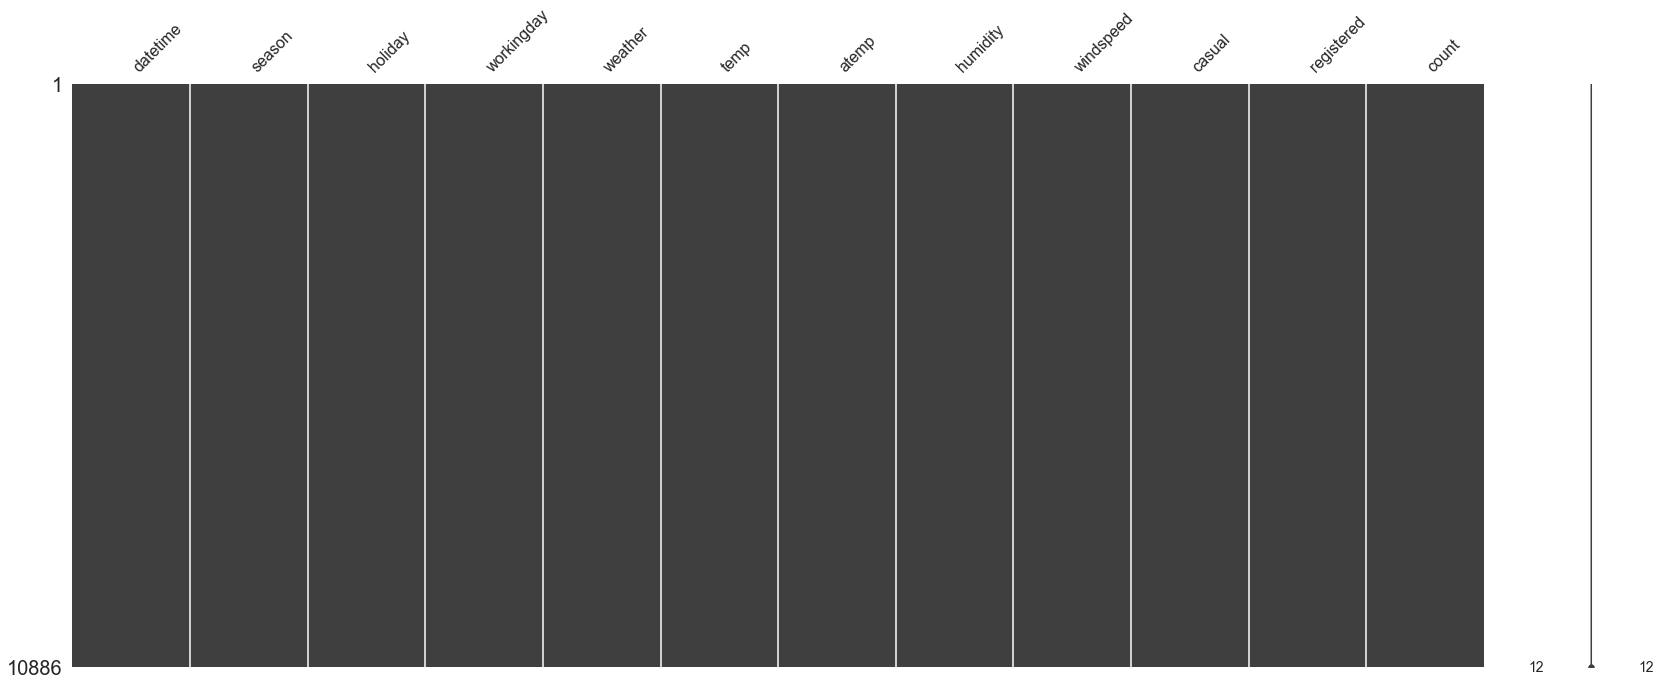

In [64]:
msno.matrix(df)  # just to visualize. no missing value.

#### 이제 우리는 우리의 피처들를 탐색 할 수 있습니다. 먼저 날씨, 계절 등과 같은 다양한 개별 피처들의 분포를 살펴보십시오.

In [65]:
# let us consider season.
df.season.value_counts() # season 변수의 데이터 갯수 확인

4    2734
3    2733
2    2733
1    2686
Name: season, dtype: int64

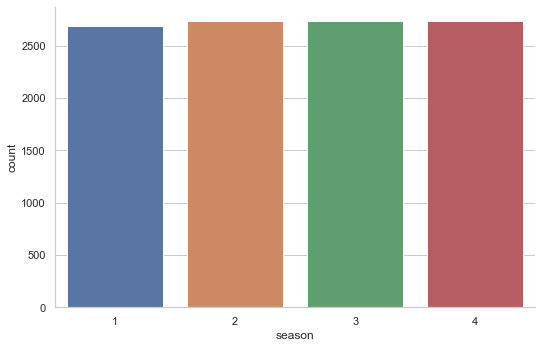

In [66]:
#sns.factorplot(x='season',data=df,kind='count',size=5,aspect=1)
sns.factorplot(x='season',data=df,kind='count',size=5,aspect=1.5) # aspect-막대그래프의 가로길이 설정

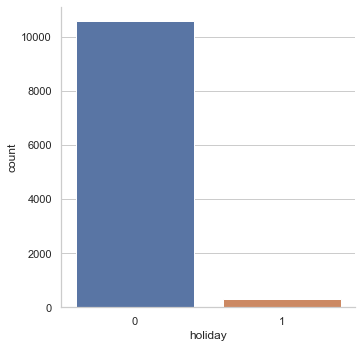

In [67]:
#holiday
df.holiday.value_counts()
sns.factorplot(x='holiday',data=df,kind='count',size=5,aspect=1) # majority of data is for non holiday days.

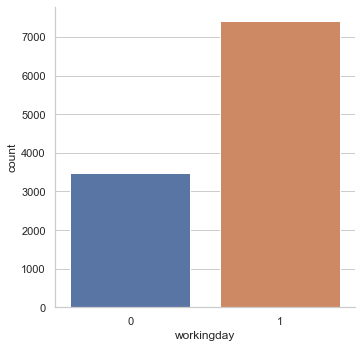

In [68]:
#holiday
df.workingday.value_counts()
sns.factorplot(x='workingday',data=df,kind='count',size=5,aspect=1) # majority of data is for working days.

In [69]:
#weather
df.weather.value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

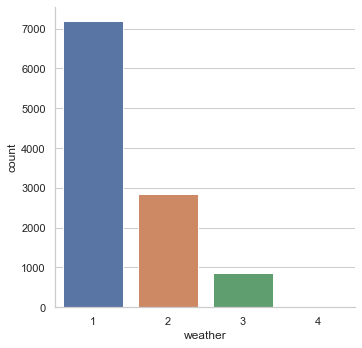

In [70]:
sns.factorplot(x='weather',data=df,kind='count',size=5,aspect=1)  
# 1-> spring
# 2-> summer
# 3-> fall
# 4-> winter

#### 이제 우리는 연속형 변수의 분포도 볼 수 있습니다.

In [71]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


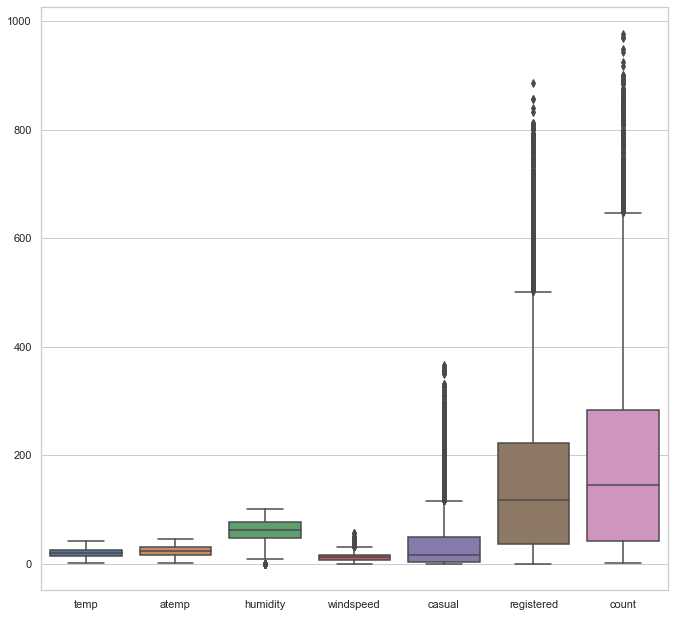

In [72]:
# just to visualize.
sns.boxplot(data=df[['temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']])
fig=plt.gcf()
fig.set_size_inches(10,10)

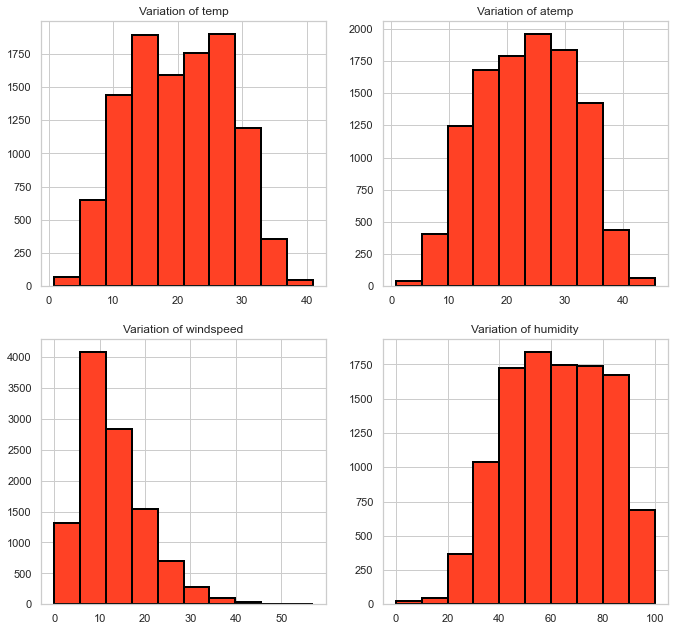

In [73]:
# can also be visulaized using histograms for all the continuous variables.
df.temp.unique()
fig,axes=plt.subplots(2,2)
axes[0,0].hist(x="temp",data=df,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,0].set_title("Variation of temp")
axes[0,1].hist(x="atemp",data=df,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,1].set_title("Variation of atemp")
axes[1,0].hist(x="windspeed",data=df,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,0].set_title("Variation of windspeed")
axes[1,1].hist(x="humidity",data=df,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,1].set_title("Variation of humidity")
fig.set_size_inches(10,10)

#### 이제 연속형 변수뿐만 아니라 다양한 이산형 변수의 분포를 확인한 후 히트 맵을 사용하여 블랙/화이트 상호 작용을 볼 수 있습니다 

<AxesSubplot:>

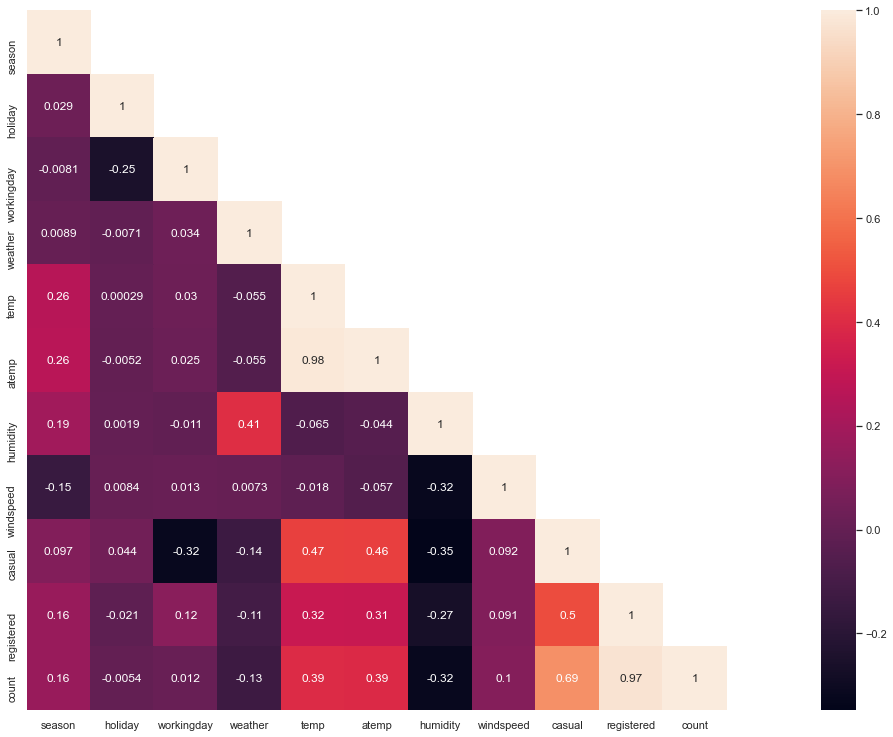

In [74]:
#corelation matrix.
mask = np.array(cor_mat) # 계산된 상관계수 열변환
mask[np.tril_indices_from(mask)] = False # 대각원소 제거/ False=대각원소 제거
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)
# sns.heatmap(data=cor_mat,
# mask=mask, # 마스크가 True인 셀에 데이터가 표시되지 않습니다. 결측값이 있는 셀은 자동으로 마스킹됩니다.(대각원소 제거)
# square=True, # 각 칸을 정사각형으로
# annot=True,cbar=True) # 숫자표시/옆에 색깔막대 표시

### 위 히트 맵의 추론-
1. 자기 실현, 즉 자신에 대한 피처는 예상대로 1과 같습니다.

2. temp와 atemp는 예상대로 매우 관련이 있습니다.

3. 습도는 사람들이 자전거를 타고 여행하는 것을 좋아하지 않을 습한 날씨이므로 예상대로 count와 반비례합니다.

3. 또한 평상시와 근무일은 예상대로 매우 반비례합니다.

4. 또한 개수와 휴일은 예상대로 매우 반비례합니다.

5. 또한 temp (또는 atemp)는 카운트에 큰 영향을 미칩니다.

6. 또한 날씨와 개수는 매우 반비례합니다. 이는 날씨가 (1에서 4로) 증가함에 따라 데이터의 경우 날씨가 더 나 빠지고 더 적은 사람들이 자전거를 빌릴 것이라는 것을 의미하기 때문입니다.

7. registered/casual 및 count는 관련성이 높기 때문에 대여한 대부분의 자전거가 등록되어 있음을 나타냅니다.

9. 비슷하게 날씨, 습도 등과 같은 추론을 더 그릴 수 있습니다 ....

### 이제 우리는 몇 가지 기능 엔지니어링을 수행하고 몇 가지 새로운 기능을 가져 와서 유용하거나 덜 관련성있는 피처를 삭제할 수 있습니다 .

In [75]:
# # seperating season as per values. this is bcoz this will enhance features.
season=pd.get_dummies(df['season'],prefix='season') # season 변수 원-핫 인코딩
# prefix-원-핫 인코딩시 변수의 접두사 지정
df=pd.concat([df,season],axis=1)
df.head()
season=pd.get_dummies(test_df['season'],prefix='season')
test_df=pd.concat([test_df,season],axis=1)
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,1,0,0,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,0,0,0
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,0,0,0
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,0,0,0
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,0,0,0


In [76]:
# # # same for weather. this is bcoz this will enhance features.
weather=pd.get_dummies(df['weather'],prefix='weather')
df=pd.concat([df,weather],axis=1)
df.head()
weather=pd.get_dummies(test_df['weather'],prefix='weather')
test_df=pd.concat([test_df,weather],axis=1)
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0


In [77]:
# # # now can drop weather and season.
df.drop(['season','weather'],inplace=True,axis=1)
df.head()
test_df.drop(['season','weather'],inplace=True,axis=1)
test_df.head()


# # # also I dont prefer both registered and casual but for ow just let them both.

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,2011-01-20 00:00:00,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0
1,2011-01-20 01:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0
2,2011-01-20 02:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0
3,2011-01-20 03:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0
4,2011-01-20 04:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0


#### 이제 가장 중요한 것은 시간이 자전거 수에 영향을 미칠 것으로 예상되므로 날짜와 시간을 분할하는 것입니다. 예를 들어 이른 아침이나 저녁과 같은 근무 시간에 자전거 대여에 대한 수요가 더 커질 것으로 예상합니다 .

In [78]:
# datetime에서 년 월 일 시간을 추출하여 새로운 변수로 지정

df["hour"] = [t.hour for t in pd.DatetimeIndex(df.datetime)]
df["day"] = [t.dayofweek for t in pd.DatetimeIndex(df.datetime)]
df["month"] = [t.month for t in pd.DatetimeIndex(df.datetime)]
df['year'] = [t.year for t in pd.DatetimeIndex(df.datetime)]
df['year'] = df['year'].map({2011:0, 2012:1}) #map-여러 개의 데이터를 한 번에 다른 형태로 변환
df.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,...,season_3,season_4,weather_1,weather_2,weather_3,weather_4,hour,day,month,year
0,2011-01-01 00:00:00,0,0,9.84,14.395,81,0.0,3,13,16,...,0,0,1,0,0,0,0,5,1,0
1,2011-01-01 01:00:00,0,0,9.02,13.635,80,0.0,8,32,40,...,0,0,1,0,0,0,1,5,1,0
2,2011-01-01 02:00:00,0,0,9.02,13.635,80,0.0,5,27,32,...,0,0,1,0,0,0,2,5,1,0
3,2011-01-01 03:00:00,0,0,9.84,14.395,75,0.0,3,10,13,...,0,0,1,0,0,0,3,5,1,0
4,2011-01-01 04:00:00,0,0,9.84,14.395,75,0.0,0,1,1,...,0,0,1,0,0,0,4,5,1,0


In [84]:
test_df["hour"] = [t.hour for t in pd.DatetimeIndex(test_df.datetime)]
test_df["day"] = [t.dayofweek for t in pd.DatetimeIndex(test_df.datetime)] # 요일별로 지정
test_df["month"] = [t.month for t in pd.DatetimeIndex(test_df.datetime)]
test_df['year'] = [t.year for t in pd.DatetimeIndex(test_df.datetime)]
test_df['year'] = test_df['year'].map({2011:0, 2012:1})
test_df.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,hour,day,month,year
0,2011-01-20 00:00:00,0,1,10.66,11.365,56,26.0027,1,0,0,0,1,0,0,0,0,3,1,0
1,2011-01-20 01:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,1,3,1,0
2,2011-01-20 02:00:00,0,1,10.66,13.635,56,0.0000,1,0,0,0,1,0,0,0,2,3,1,0
3,2011-01-20 03:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,3,3,1,0
4,2011-01-20 04:00:00,0,1,10.66,12.880,56,11.0014,1,0,0,0,1,0,0,0,4,3,1,0


In [85]:
# now can drop datetime column.
df.drop('datetime',axis=1,inplace=True)
df.head()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,season_1,...,season_3,season_4,weather_1,weather_2,weather_3,weather_4,hour,day,month,year
0,0,0,9.84,14.395,81,0.0,3,13,16,1,...,0,0,1,0,0,0,0,5,1,0
1,0,0,9.02,13.635,80,0.0,8,32,40,1,...,0,0,1,0,0,0,1,5,1,0
2,0,0,9.02,13.635,80,0.0,5,27,32,1,...,0,0,1,0,0,0,2,5,1,0
3,0,0,9.84,14.395,75,0.0,3,10,13,1,...,0,0,1,0,0,0,3,5,1,0
4,0,0,9.84,14.395,75,0.0,0,1,1,1,...,0,0,1,0,0,0,4,5,1,0


#### 이제 새로운 피처를 살펴보십시오.

<AxesSubplot:>

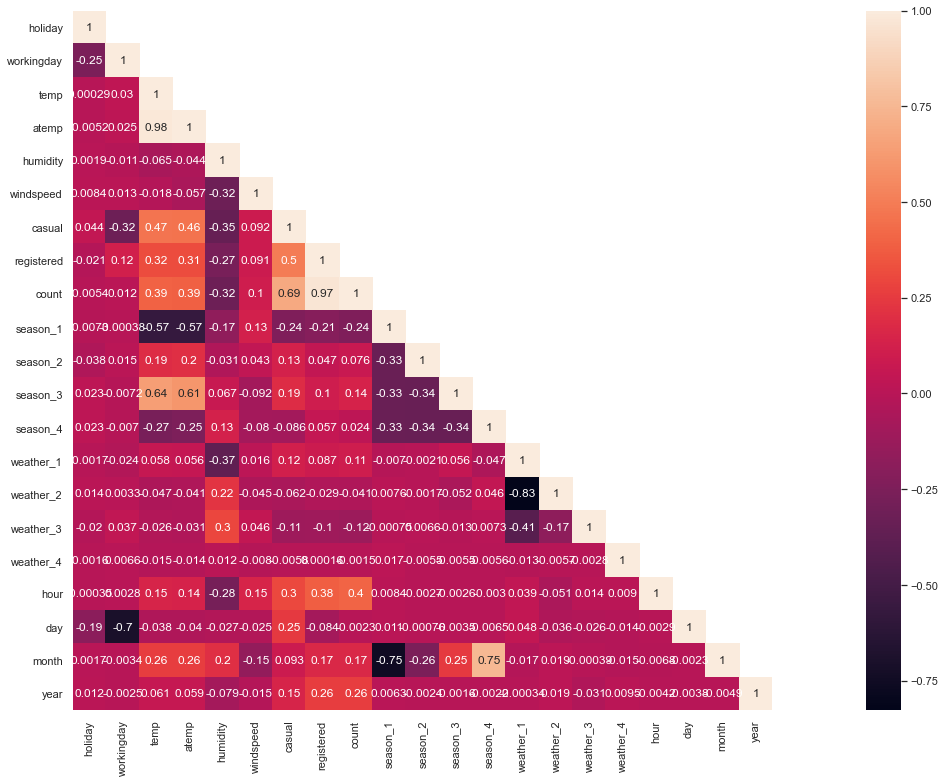

In [86]:
cor_mat= df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [88]:
df.drop(['casual','registered'],axis=1,inplace=True)

자전거 사용시 가입여부는 타겟값에 의미를 두지않아 변수를 제거하는 듯함

In [89]:
df.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,hour,day,month,year
0,0,0,9.84,14.395,81,0.0,16,1,0,0,0,1,0,0,0,0,5,1,0
1,0,0,9.02,13.635,80,0.0,40,1,0,0,0,1,0,0,0,1,5,1,0
2,0,0,9.02,13.635,80,0.0,32,1,0,0,0,1,0,0,0,2,5,1,0
3,0,0,9.84,14.395,75,0.0,13,1,0,0,0,1,0,0,0,3,5,1,0
4,0,0,9.84,14.395,75,0.0,1,1,0,0,0,1,0,0,0,4,5,1,0


이제 다양한 피처에 따라 count가 어떻게 달라지는지 살펴보겠습니다.

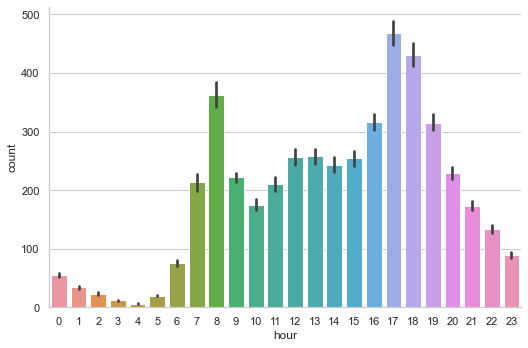

In [90]:
# with hour.
sns.factorplot(x="hour",y="count",data=df,kind='bar',size=5,aspect=1.5)

#### 가장 높은 수요는 7-10 시간과 15-19 시간입니다. 이것은 대부분의 대도시에서 이시간이 출퇴근 시간의 절정이기 때문에 더 많은 사람들이 자전거를 빌릴 것입니다. 이것은 그럴듯한 이유 중 하나일뿐입니다.

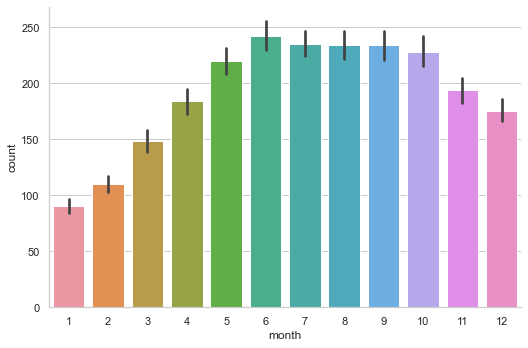

In [91]:
sns.factorplot(x="month",y="count",data=df,kind='bar',size=5,aspect=1.5)
# month는 season에 영향을 미치며 비, 실안개 등 기후 조건처럼 사람들이 자전거를 타는 지 여부에 영향을 미칩니다. 

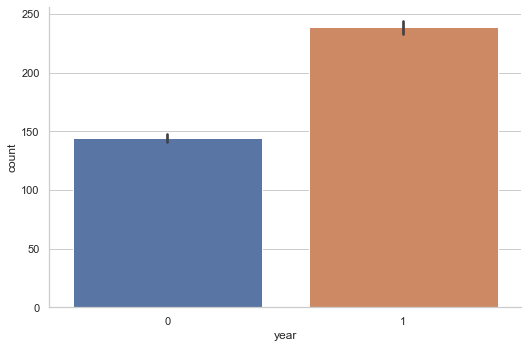

In [92]:
sns.factorplot(x="year",y="count",data=df,kind='bar',size=5,aspect=1.5)
# 2011년은 0, 2012년은 1. 따라서 수요는 해가 바뀌며 증가했습니다.

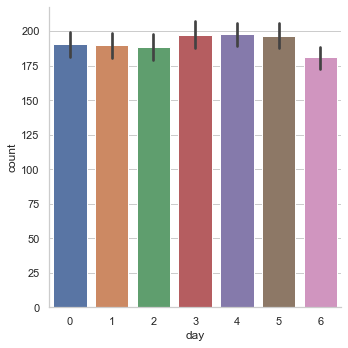

In [93]:
sns.factorplot(x="day",y='count',kind='bar',data=df,size=5,aspect=1)
# 0부터 월요일

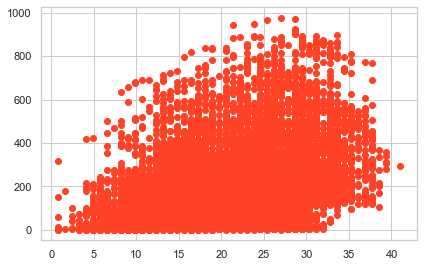

In [98]:
# for temp
plt.scatter(x="temp",y="count",data=df,color='#ff4125')

#### 이 방법은 시각화하기 어렵습니다. 더 좋은 방법은 'temp'변수를 간격 또는 소위 bin으로 변환한 다음 이산 변수처럼 취급하는 것입니다.

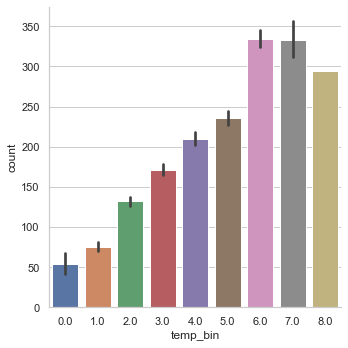

In [99]:
new_df=df.copy()
new_df.temp.describe()
new_df['temp_bin']=np.floor(new_df['temp'])//5 # np.floor-소숫점 숫자보다 낮은 값 출력 후 5로 나눈 후 소숫점 버림
new_df['temp_bin'].unique()
# now we can visualize as follows
sns.factorplot(x="temp_bin",y="count",data=new_df,kind='bar')

#### 이제 온도 30-35 (빈 6) 및 35-40 (빈 7)에 대한 빈 6과 7에 대한 수요가 가장 높습니다.

유사하게 우리는 다른 연속 변수에 대해 적용할 수 있고 그것이 target 변수에 어떻게 영향을 미치는지 볼 수 있습니다.

#### 이제 데이터 탐색, 분석, 시각화 및 사전 처리가 완료되었으며 이제 모델링 부분으로 이동할 수 있습니다.

In [140]:
df.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,hour,day,month,year
0,0,0,9.84,14.395,81,0.0,16,1,0,0,0,1,0,0,0,0,5,1,0
1,0,0,9.02,13.635,80,0.0,40,1,0,0,0,1,0,0,0,1,5,1,0
2,0,0,9.02,13.635,80,0.0,32,1,0,0,0,1,0,0,0,2,5,1,0
3,0,0,9.84,14.395,75,0.0,13,1,0,0,0,1,0,0,0,3,5,1,0
4,0,0,9.84,14.395,75,0.0,1,1,0,0,0,1,0,0,0,4,5,1,0


In [141]:
df.columns.to_series().groupby(df.dtypes).groups # 같은 타입의 변수들끼리 묶은 후 확인

{uint8: ['season_1', 'season_2', 'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3', 'weather_4'], int64: ['holiday', 'workingday', 'humidity', 'count', 'hour', 'day', 'month', 'year'], float64: ['temp', 'atemp', 'windspeed']}

In [194]:
x_train,x_test,y_train,y_test=train_test_split(df.drop('count',axis=1),df['count'],test_size=0.25,random_state=42)

In [171]:
models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor']
rmsle=[]
d={}

x_train = np.log1p(x_train)
x_test = np.log1p(x_test)
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

for model in range (len(models)):
    clf=models[model]
    clf.fit(x_train,y_train)
    test_pred=clf.predict(x_test)
    rmsle.append(np.sqrt(mean_squared_error(test_pred,y_test)))
d={'Modelling Algo':model_names,'RMSLE':rmsle}   
d

{'Modelling Algo': ['RandomForestRegressor',
  'AdaBoostRegressor',
  'BaggingRegressor',
  'SVR',
  'KNeighborsRegressor'],
 'RMSLE': [0.07874038495747925,
  0.1632793819644786,
  0.08252768607290369,
  0.20247744446012375,
  0.15561745776877295]}

본 kaggle notebook에서는 mean_squared_log_error Mean Squared Logarithmic Error cannot be used when targets contain negative values. 이라는 에러가 떴다. 이는 log 변환과정에서 0인 데이터 때문으로 log1p()을 통하여 미리 log(1+x)로 변환을 한 뒤 mean_squared_error 함수를 사용하여 rmsle를 구하였다.

In [172]:
rmsle_frame=pd.DataFrame(d)
rmsle_frame

,Modelling Algo,RMSLE
0,RandomForestRegressor,0.078740
1,AdaBoostRegressor,0.163279
2,BaggingRegressor,0.082528
3,SVR,0.202477
4,KNeighborsRegressor,0.155617


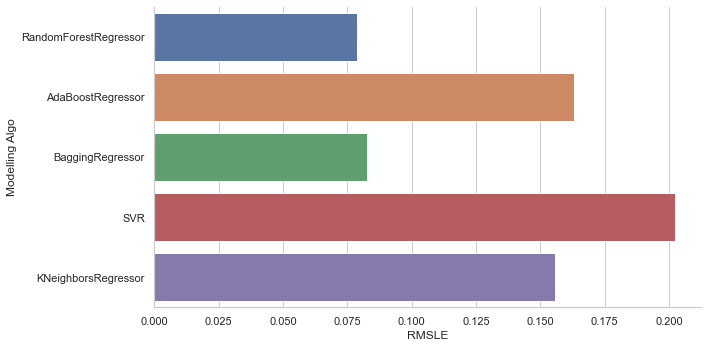

In [173]:
sns.factorplot(y='Modelling Algo',x='RMSLE',data=rmsle_frame,kind='bar',size=5,aspect=2)

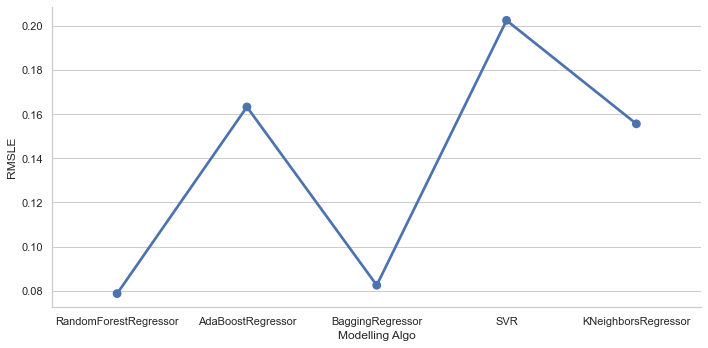

In [174]:
sns.factorplot(x='Modelling Algo',y='RMSLE',data=rmsle_frame,kind='point',size=5,aspect=2)

#### 선형 회귀, RIDGE 및 RIDGECV와 같은 다른 모델링 알고리즘이 있지만 문제는 해당 모델이 불가능한 count target에 대해 음수 값으로 예측한다는 것입니다. 이제 나는 이런 경우에 무엇을 해야할지 모르겠다 :: :) !!!!!!!!!!!!!!!

#### 이제 조금 조정 해보자 ...

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(df.drop('count',axis=1),df['count'],test_size=0.25,random_state=42)

In [199]:
#for random forest regresion.
no_of_test=[500]
params_dict={'n_estimators':no_of_test,'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}
clf_rf=GridSearchCV(estimator=RandomForestRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
clf_rf.fit(x_train,y_train)
pred=clf_rf.predict(x_test)
print((np.sqrt(mean_squared_log_error(pred,y_test))))

0.31934746309823386


In [188]:
clf_rf.best_params_

{'max_features': 'auto', 'n_estimators': 500, 'n_jobs': -1}

In [197]:
# for KNN
n_neighbors=[]
for i in range (0,50,5):
    if(i!=0):
        n_neighbors.append(i)
params_dict={'n_neighbors':n_neighbors,'n_jobs':[-1]}
clf_knn=GridSearchCV(estimator=KNeighborsRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
clf_knn.fit(x_train,y_train)
pred=clf_knn.predict(x_test)
print((np.sqrt(mean_squared_log_error(pred,y_test))))

0.8616609594892403


In [198]:
clf_knn.best_params_

{'n_jobs': -1, 'n_neighbors': 5}

#### 이제 RANDOM FORETS REGRESSOR가 최소한의 규칙을 제공합니다. 따라서 우리는 케글에 대한 예측을 하기 위해 그것을 사용합니다.

In [204]:
pred=clf_rf.predict(test_df.drop('datetime',axis=1))
d={'datetime':test['datetime'],'count':pred}
ans=pd.DataFrame(d)
ans
# ans.to_csv('answer.csv',index=False) # saving to a csv file for predictions on kaggle.

,datetime,count
0,2011-01-20 00:00:00,12.184
1,2011-01-20 01:00:00,4.756
2,2011-01-20 02:00:00,3.602
3,2011-01-20 03:00:00,3.140
4,2011-01-20 04:00:00,2.754
...,...,...
6488,2012-12-31 19:00:00,297.596
6489,2012-12-31 20:00:00,206.352
6490,2012-12-31 21:00:00,144.590
6491,2012-12-31 22:00:00,109.154


#### THE END.